In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import pickle
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

### Reading and Plotting Image

(602, 900, 3)

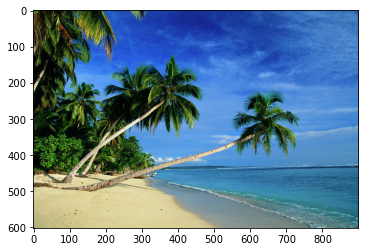

In [2]:
# Reading image of size 602*900 
ogimage = skio.imread(fname="OriginalImage.jpg")

# Showing length and breadth and type of image
ogimage.shape

# Plotting image 
plt.imshow(ogimage)

(301, 450, 3)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


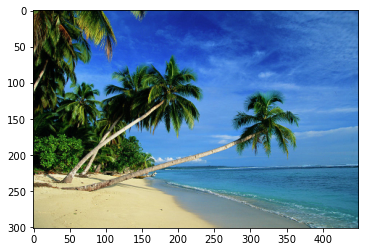

In [3]:
#reducing resolution of the image
ogimage_resized = resize(ogimage, (ogimage.shape[0] // 2, ogimage.shape[1] // 2),
                       anti_aliasing=False)
plt.imshow(ogimage_resized)
ogimage_resized.shape

# Saving image
skio.imsave(fname="ogimage_resized.jpg", arr=ogimage_resized)

In [4]:
# Reading the resized image 
ogimage_resized = skio.imread(fname="ogimage_resized.jpg")

# Converting resized RGB image to equivalent Grayscale image 
ogimage_grey = ogimage_resized[:,:,0]*0.21 + ogimage_resized[:,:,1]*0.72 + ogimage_resized[:,:,2]*0.07

### Splitting image in training and testing data

In [5]:
ogimage_resized.shape

# Training data
trainingImage = ogimage_resized[:,0:225,:]
trainingImage.shape

# Testing data
testingImage = ogimage_resized[:,225:450,:]
testingImage.shape

(301, 450, 3)

(301, 225, 3)

(301, 225, 3)

### Plotting colors points in training image

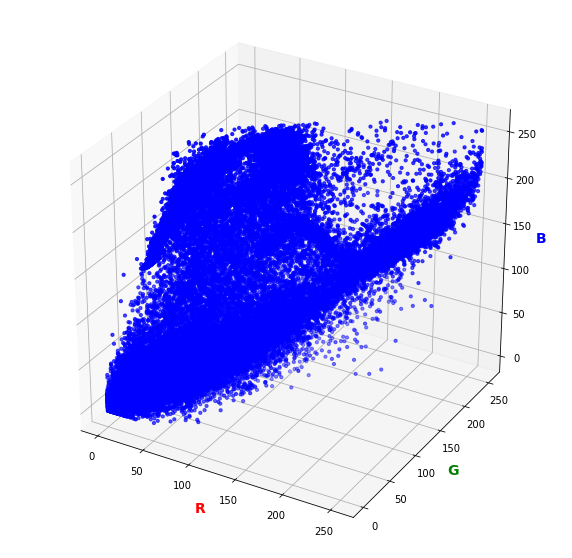

In [6]:
fig = plt.figure(figsize=(10,10))

# Plotting 3d data
ax = fig.gca(projection='3d')

# Assigning the data
ax.scatter(xs = trainingImage[:,:,0], ys = trainingImage[:,:,1], zs = trainingImage[:,:,2], s=10, c='b', depthshade=True)

# Labelling
x_label = ax.set_xlabel('R', fontsize=14, fontweight='bold', color='r')
y_label = ax.set_ylabel('G',fontsize=14, fontweight='bold', color='g')
z_label = ax.set_zlabel('B',fontsize=14, fontweight='bold', color='b')

### Defining methods for K-mean clustering.

#### We have used Kmean ++ algorithm for initialising the centers rather than randomly picking centers

In [59]:
# Intializing centers 
def initializecenters(data,k,distf):
    centers =  data[random.sample(range(0,data.shape[0]-1), 1)]
    while (centers.shape[0]<k):
        distvalue = np.array([min([dist(c,pixel,distf) for c in centers]) for pixel in data])
        probs = distvalue/distvalue.sum()
        cusum = probs.cumsum()
        r = random.random()
        ind = np.where(cusum >= r)[0][0]
        centers = np.vstack((centers,data[ind]))
    centers = centers[centers[:,0].argsort()]
    return centers


# Function to compute euclidean distance 
def dist(a,b,distf):
    if distf=="color":
        distvalue = np.sqrt(2*((a[0] - b[0])**2) + 4*((a[1] - b[1])**2) + 3*((a[2] - b[2])**2))
    else:
        dists = [np.square(a[i] - b[i]) for i in range(0,len(a))]
        distvalue = np.sqrt(np.sum(dists))
    return distvalue


# Dictionary holding centers and updating
def returndic(k):
    centerdic = {}    
    for c in range(k):
        centerdic.update({c : set()})
    return centerdic

# Cluster holding minimum index and adding to new center dictionary
def returncluster(data,k,centers,distf):
    newcenterdic = returndic(k)
    for ind,pixel in enumerate(data):
        distvalues = list(map(lambda c:dist(c,pixel,distf), centers))
        minindex = distvalues.index(min(distvalues))
        newcenterdic.get(minindex).add(ind)
    return newcenterdic
    
# Function to compute new centers  
def is_converged(newcenters, oldcenters):
    return set([tuple(a) for a in newcenters]) == set([tuple(a) for a in oldcenters])


def computeloss(centers,centerdic,data,distf):
    sqdisvalues =  list()
    for index,center in enumerate(centers):
        sqdisvalues.extend(list(map(lambda p:dist(p,center,distf)**2, data[list(centerdic.get(index))])))
    return sum(sqdisvalues)/len(sqdisvalues)
    
    

#### Normalizing data

In [426]:
RGB = trainingImage.reshape(((trainingImage.shape[0]*trainingImage.shape[1]),3))
RGBnorm = (RGB - np.mean(RGB,axis=0))/np.std(RGB,axis=0)
RGB.shape
RGBnorm.shape

(67725, 3)

(67725, 3)

In [118]:
# Kmeans

def Kmean(data,k,maxiter,distf):
    converged = False
    i = 1
    centers = initializecenters(data,k,distf)
    while((not converged) and i<maxiter):
        centerdic = returncluster(data,k,centers,distf)
        oldcenters = centers.copy()
        for c in range(k):
            centers[c] = (np.mean(data[list(centerdic.get(c))], axis = 0))
        converged = is_converged(centers,oldcenters)
        i += 1
    return centers,i

        

#### Creating clusters for colors for K = 5

In [295]:
k = 5
maxiter = 100
distf = "color"

# Collecting centers
centers,iterations = Kmean(RGBnorm,k,maxiter,distf)
print("Iterations to converge :: " + str(iterations))
centers = (centers * np.std(RGB1,axis=0)) + np.mean(RGB1,axis=0)

# Approximating centers
centers =  np.rint(centers)
centers

Iterations to converge :: 22


array([[ 78., 102.,  59.],
       [ 17.,  31.,  12.],
       [ 36.,  82., 189.],
       [ 94., 151., 204.],
       [213., 203., 153.]])

In [323]:
# Training Data and Output Image

clustersForTrainingData = returncluster(RGB,k,centers,distf)
for index,center in enumerate(centers):
    RGB[list(clustersForTrainingData.get(index))] = center
trainingOutputImage = RGB.reshape((trainingImage.shape[0],trainingImage.shape[1],3))

(301, 225, 3)

array([ 78, 102,  59], dtype=uint8)

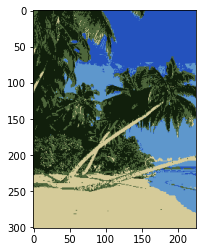

In [324]:
trainingOutputImage.shape
plt.imshow(trainingOutputImage)
skio.imsave(fname="trainingOutputImage.jpg", arr=trainingOutputImage)
tempfile = open('Variables/trainingOutputImage.pckl', 'wb')
pickle.dump(trainingOutputImage, tempfile)
trainingOutputImage[0,0]
tempfile.close()

In [67]:
clusters = {}
for index,center in enumerate(centers):
    clusters.update({tuple(center) : clustersForTrainingData.get(index)})
tempfile = open('Variables/clusters.pckl', 'wb')
pickle.dump(clusters, tempfile)
tempfile.close()

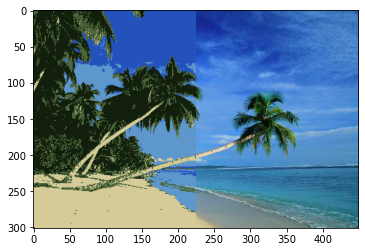

In [68]:
# Complete Image with training and testing

complete_image = np.column_stack((trainingOutputImage,testingImage))
plt.imshow(complete_image)

Lossy conversion from float64 to uint8. Range [0.0, 254.79]. Convert image to uint8 prior to saving to suppress this warning.


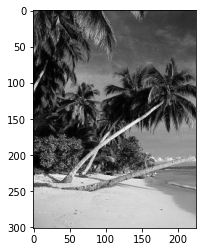

In [69]:
# Training Image converted to Grayscale 

trainingInputImage = trainingImage[:,:,0]*0.21 + trainingImage[:,:,1]*0.72 + trainingImage[:,:,2]*0.07
plt.imshow(trainingInputImage,cmap=plt.cm.gray)
skio.imsave(fname="trainingInputImage.jpg", arr=trainingInputImage)

Lossy conversion from float64 to uint8. Range [0.35000000000000003, 250.08]. Convert image to uint8 prior to saving to suppress this warning.


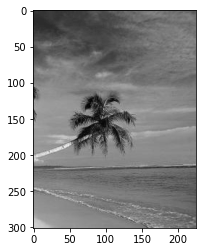

In [70]:
# Testing Image equivalent grayscale conversion

testingInputImage= testingImage[:,:,0]*0.21 + testingImage[:,:,1]*0.72 + testingImage[:,:,2]*0.07
plt.imshow(testingInputImage,cmap=plt.cm.gray)
skio.imsave(fname="testingInputImage.jpg", arr=testingInputImage)

In [511]:
# Using pickle to read file and load

tempfile = open('Variables/clusters.pckl', 'rb')
colorclusters = pickle.load(tempfile)
colorcenters = list(colorclusters.keys())
tempfile.close()
RGBtest = testingImage.reshape((testingImage.shape[0]*testingImage.shape[1],3))

# Clusters for testing data
k = 5
distf = "color"
clustersForTestingData = returncluster(RGBtest,k,colorcenters,distf)
for index,center in enumerate(colorcenters):
    RGBtest[list(clustersForTestingData.get(index))] = center
expectedtestingOutputImage = RGBtest.reshape((testingImage.shape[0],testingImage.shape[1],3))
tempfile = open('Variables/expectedtestingOutputImage.pckl', 'wb')
pickle.dump(expectedtestingOutputImage, tempfile)
tempfile.close()
skio.imsave(fname="expectedtestingOutputImage.jpg", arr=expectedtestingOutputImage)

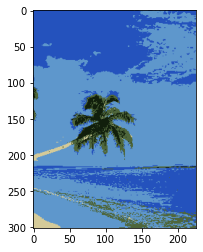

In [512]:
plt.imshow(expectedtestingOutputImage)

#### Best value of K using elbow method

Text(0.5, 1.0, 'Elbow Method')

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'WCSS')

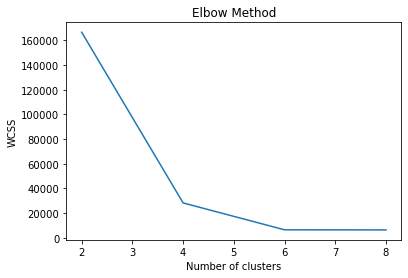

In [87]:
runs = 10
wcss = np.empty((runs,len((range(2,10,2)))))
maxiter = 100
distf = "color"
for i in range(runs):
    wcssi = np.empty((1,0))
    for k in range(2,10,2):
        centers,iterations = Kmean(RGBnorm,k,maxiter,distf)
        centers = (centers * np.std(RGB,axis=0)) + np.mean(RGB,axis=0)
        centers =  np.rint(centers)
        clusters = returncluster(RGB,k,centers,distf)
        loss = computeloss(centers,clusters,RGB,distf)
        wcssi = np.column_stack((wcssi,loss))
    wcss[i] = wcssi
plt.plot(range(2,10,2), np.sum(wcss,axis=0))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')       

#### Creating array with 3X3 patch values for each pixel 

In [22]:
# Reading Training side of the image 

trainingInputImage = skio.imread(fname="trainingInputImage.jpg")

In [29]:
def returnpatch(image,indices,patchsize):
    patch = np.empty((1,0))
    prange = list(range(-patchsize+2,patchsize-1))
    for k in prange:
        for l in prange:
            patch = np.column_stack((patch,image[indices[0] + k,indices[1] +l]))
    return patch

def returnpatharray(image,patchsize):
    patcharray = np.empty((0,patchsize**2))
    for i in range(1,image.shape[0] -1):
        for j in range(1,image.shape[1] -1):
            patcharray = np.row_stack((patcharray,returnpatch(image,(i,j),patchsize)))
    return patcharray

In [30]:
trainImagePatchArray = returnpatharray(trainingInputImage,3)        

In [31]:
trainImagePatchArray.shape
tempfile = open('Variables/trainImagePatchArray.pckl', 'wb')
pickle.dump(trainImagePatchArray, tempfile)
tempfile.close()

(66677, 9)

In [32]:
# Reading testing image and returning array

testingInputImage = skio.imread(fname="testingInputImage.jpg")
testImagePatchArray = returnpatharray(testingInputImage,3)
testImagePatchArray.shape
tempfile = open('Variables/testImagePatchArray.pckl', 'wb')
pickle.dump(testImagePatchArray, tempfile)
tempfile.close()

(66677, 9)

#### Clustering of gray scale training image

In [39]:
tempfile = open('Variables/trainImagePatchArray.pckl', 'rb')
trainImagePatchArray = pickle.load(tempfile)
tempfile.close()

In [44]:
trainImagePatchArraynorm = (trainImagePatchArray - trainImagePatchArray.mean(axis = 0))/trainImagePatchArray.std(axis = 0)

In [425]:
k = 50
maxiter = 100
distf = "euclidien"
greycenters,iterations = Kmean(trainImagePatchArraynorm,k,maxiter,distf)

In [428]:
greycenters = np.rint(greycenters*trainImagePatchArray.std(axis = 0)+trainImagePatchArray.mean(axis = 0))

In [430]:
gclusters = returncluster(trainImagePatchArray,k,greycenters,distf)

In [433]:
greyclusters = {}
for index,center in enumerate(greycenters):
    greyclusters.update({tuple(center) : gclusters.get(index)})

tempfile = open('Variables/greyclusters.pckl', 'wb')
pickle.dump(greyclusters, tempfile)
tempfile.close()

#### Recoloring Test input image using Training input image as reference

In [434]:
tempfile = open('Variables/greyclusters.pckl', 'rb')
greyclusters =  pickle.load(tempfile)
greycenters = list(greyclusters.keys())

tempfile = open('Variables/trainingOutputImage.pckl', 'rb')
trainingOutputImage = pickle.load(tempfile)
tempfile.close()

trainout = trainingOutputImage.reshape(((trainingOutputImage.shape[0]*trainingOutputImage.shape[1]),3))
trainIn = trainImagePatchArray

In [472]:
testOutputImage = np.zeros((len(testImagePatchArray),3))

In [ ]:
# Finding equivalent RGB values for Grayscale image

for pindex,patch in enumerate(testImagePatchArray):
    # Values of distances from the center
    distvalues = [dist(center,patch,distf) for center in greycenters]
    # Finding the centers with min distance
    center = greycenters[distvalues.index(min(distvalues))]
    patchdistvalues = [dist(patch,trainIn[patchindex],distf) for patchindex in greyclusters.get(tuple(center))]
    # sort the values which are unique
    patchdistvaluessort= np.sort(np.unique(patchdistvalues))
    # Initialize the find 
    find = np.empty((1,0), dtype =int)
    i = 0 
    # Limit the find size below 6
    while (find.size<6):
        mini=np.where(patchdistvalues==patchdistvaluessort[i])
        find = np.column_stack((find,mini))
        i = i+1
    find=find[0,0:6]
    # Equivalent probable RGB values
    probableRGB = trainout[find]
    countdic = Counter(tuple(rgb) for rgb in probableRGB)
    # RGB values 
    rgbvalues = [np.asarray(key) for key in countdic.keys() if countdic.get(key) == max(list(countdic.values()))]
    # initilizing index
    index = np.empty((1,0), dtype =int)
    for values in rgbvalues:
        index = np.column_stack((index,np.where((probableRGB == values).all(axis=1))))
    testOutputImage[pindex] = probableRGB[min(index[0])]

In [478]:
testOutputImage.shape

(66677, 3)

In [493]:
testOutputImage = (testOutputImage.reshape((testingInputImage.shape[0]-2,testingInputImage.shape[1]-2,3))).astype(int)

In [495]:
tempfile = open('Variables/testOutputImage.pckl', 'wb')
pickle.dump(testOutputImage, tempfile)
tempfile.close()
skio.imsave(fname="testOutputImage.jpg", arr=testOutputImage)

Lossy conversion from int32 to uint8. Range [12, 213]. Convert image to uint8 prior to saving to suppress this warning.


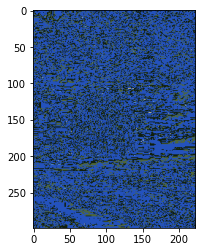

In [507]:
plt.imshow(testOutputImage)

In [513]:
tempfile = open('Variables/expectedtestingOutputImage.pckl', 'rb')
expectedtestingOutputImage = pickle.load(tempfile)
tempfile.close()

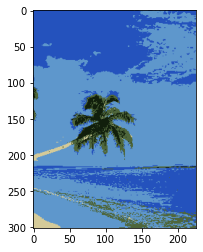

In [515]:
# Testing data Final Image
plt.imshow(expectedtestingOutputImage)

In [5]:
# Recoloaration Error
print("Recoloration Error")
np.round(np.sum((expectedtestingOutputImage[1:300,1:224] - testOutputImage)**2)/testOutputImage.size,3)

Recoloration Error


6335.691

In [6]:
# Accuracy
print("Recoloration Accuracy")
np.round(np.sum(np.equal(expectedtestingOutputImage[1:300,1:224].reshape(testOutputImage.shape[0]*testOutputImage.shape[1],3),testOutputImage.reshape(testOutputImage.shape[0]*testOutputImage.shape[1],3)).all(axis=1))/(testOutputImage.shape[0]*testOutputImage.shape[1])*100,3)

Recoloration Accuracy


21.085